In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Install spark-related dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark


!pip install pyspark



In [0]:
# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, sum


from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import isnan, when, count, col, avg,monotonically_increasing_id,max,regexp_replace,mean,stddev,unix_timestamp
from pyspark.ml.feature import Imputer,VectorAssembler

import numpy as np

!pip install plotly
import plotly
import plotly.graph_objs as go
import plotly.express as px


import pandas as pd
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

import pathlib as pl
import matplotlib.pyplot as plt


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
calender = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Project/calendar.csv", header=True)
listings = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Project/listings.csv", header=True, escape="\"", multiLine=True,  inferSchema=True)
listings_detailed = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Project/listings_detailed.csv", header=True, escape="\"", multiLine=True,  inferSchema=True)
neighborhoods = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Project/neighbourhoods.csv", header=True, escape="\"", multiLine=True,  inferSchema=True)
reviews_date = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Project/reviews_date.csv", header=True,  inferSchema=True)
reviews_detailed = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Project/reviews_detailed.csv", header=True, escape="\"", multiLine=True,  inferSchema=True)
train_review = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Project/train.csv")



---



##Now that we loaded up our files, let us do some data cleaning =)


---


But first things first,
we can see that we have listings and listings_detailed, they are similar in some ways, but it is more detailed on one side than the other, so let us **join** these two Datasets together 

But one problem though, we have some similarly named columns in both, so first  I will drop them in one of these datas.



In [0]:
listings.show(3)

+-----+--------------------+-------+---------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-------------------+-----------------+------------------------------+----------------+
|   id|                name|host_id|host_name|neighbourhood_group|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|        last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+-----+--------------------+-------+---------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-------------------+-----------------+------------------------------+----------------+
| 2818|Quiet Garden View...|   3159|   Daniel|               null|Oostelijk Havenge...|52.36575|  4.94142|   Private room|   59|             3|              278|2020-02-14 00:00:00|             2.08|                             1|              81|
|20168|S

In [0]:
listings_detailed.show(3)

+-----+--------------------+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------+--------------------+--------------+-------+--------------------+---------+-------------------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+--------------+----------------------+----------------------------+---------+-------------+-------+---------+--------------------+------------+-----------+--------+---------+-----------------+-------------+---------------+------------+---------+--------+----+--------+------

In [0]:
for x in listings.columns:
  for j in listings_detailed.columns:
    if x==j and x!="id":
      listings_detailed = listings_detailed.drop(x)

After removing those duplicated columns, let us join these two datas !

In [0]:
bigListings = listings.join(listings_detailed, 'id', 'outer')
bigListings.show()

+-------+--------------------+--------+----------------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-------------------+-----------------+------------------------------+----------------+--------------------+--------------+-------------------+--------------------+--------------------+--------------------+-------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------+--------------------+--------------+--------------------+-------------------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+--------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+---------

In listings and listings_deteailed, there are some columns that will be irrelevant to us.
So let us pick some of the data that actually matters to us.


In [0]:
columns_to_keep = ['id',
 'name',
 'host_id',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'property_type', 'accommodates','bathrooms','bedrooms','beds','cleaning_fee','security_deposit', 'amenities', 'square_feet',
 'minimum_nights', 'maximum_nights',
 'number_of_reviews',
 'review_scores_value', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_checkin', 'review_scores_rating',
 'reviews_per_month',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',]


bigListings = bigListings.select(columns_to_keep)

First let us check what Null values need replacing or what values would act as a bias.


In [0]:
bigListings.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19636 entries, 0 to 19635
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           19635 non-null  float64
 1   name                         19602 non-null  object 
 2   host_id                      19635 non-null  float64
 3   neighbourhood                19635 non-null  object 
 4   latitude                     19635 non-null  float64
 5   longitude                    19635 non-null  float64
 6   room_type                    19635 non-null  object 
 7   price                        19635 non-null  float64
 8   property_type                19634 non-null  object 
 9   accommodates                 19634 non-null  float64
 10  bathrooms                    19628 non-null  float64
 11  bedrooms                     19615 non-null  float64
 12  beds                         19550 non-null  float64
 13  cleaning_fee    


As we can see, some values are missing like in "beds,reviews..etc."
However, values like "square_feet" with only 352 non-null values, would act as a bias, and it is better if we remove it.

In [0]:
bigListings = bigListings.drop("square_feet")

We will also need the cleaning_fee and security_deposit for the Price predictions, but they have alot of missing value.
But as we know, **a missing price value means, it is free :D** (a.k.a 0$)

In [0]:
bigListings.fillna("$0.00", subset=['cleaning_fee', 'security_deposit'])

DataFrame[id: int, name: string, host_id: int, neighbourhood: string, latitude: double, longitude: double, room_type: string, price: int, property_type: string, accommodates: int, bathrooms: double, bedrooms: int, beds: int, cleaning_fee: string, security_deposit: string, amenities: string, minimum_nights: int, maximum_nights: int, number_of_reviews: int, review_scores_value: int, review_scores_cleanliness: int, review_scores_location: int, review_scores_accuracy: int, review_scores_communication: int, review_scores_checkin: int, review_scores_rating: int, reviews_per_month: double, availability_30: int, availability_60: int, availability_90: int, availability_365: int]

Now let us remove the dollar signs from these two columns

In [0]:
def remove_all_dollars(col):
    return regexp_replace(col, "\$", "")

bigListings = bigListings.withColumn('cleaning_fee', remove_all_dollars(bigListings['cleaning_fee']))
bigListings = bigListings.withColumn('security_deposit', remove_all_dollars(bigListings['security_deposit']))
bigListings.select("cleaning_fee","security_deposit").show(2)

+------------+----------------+
|cleaning_fee|security_deposit|
+------------+----------------+
|       45.00|          750.00|
|       40.00|          100.00|
+------------+----------------+
only showing top 2 rows



Time to fill in all the other missing values using **Imputer**

In [0]:
exceptions = ['id','name','longitude','latitude','host_id','neighbourhood','room_type','property_type','amenities']

toFill = []

for i in bigListings.columns :
  if i not in exceptions:
    toFill.append(i)
    bigListings = bigListings.withColumn(i, bigListings[i].cast('double'))


# We use Imputer in order to fill in the missing values
imputer = Imputer(
inputCols=toFill,
outputCols=toFill)
bigListings = imputer.fit(bigListings).transform(bigListings)



bigListings.show()

+-------+--------------------+--------+--------------------+--------+---------+---------------+-----+------------------+------------+---------+--------+----+------------------+------------------+--------------------+--------------+--------------+-----------------+-------------------+-------------------------+----------------------+----------------------+---------------------------+---------------------+--------------------+-----------------+---------------+---------------+---------------+----------------+
|     id|                name| host_id|       neighbourhood|latitude|longitude|      room_type|price|     property_type|accommodates|bathrooms|bedrooms|beds|      cleaning_fee|  security_deposit|           amenities|minimum_nights|maximum_nights|number_of_reviews|review_scores_value|review_scores_cleanliness|review_scores_location|review_scores_accuracy|review_scores_communication|review_scores_checkin|review_scores_rating|reviews_per_month|availability_30|availability_60|availability

Now that the values have been filled, Let us get to the real work =)



---

#Now let us start by visualizing all our Data !

First I will use the GeoJSON file in order to view our areas

In [0]:
nbdgeo = spark.read.json('/content/drive/My Drive/Colab Notebooks/Project/neighbourhoods.geojson', multiLine=True)
nbdgeo.printSchema()

root
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- geometry: struct (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |-- properties: struct (nullable = true)
 |    |    |    |-- neighbourhood: string (nullable = true)
 |    |    |    |-- neighbourhood_group: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- type: string (nullable = true)



In [0]:
amsterdam_geo = '/content/drive/My Drive/Colab Notebooks/Project/neighbourhoods.geojson'
fullCity = folium.Map(location=[52.3480, 4.9136],width=1000,height=1000, zoom_start=11.5)

folium.Choropleth(
    geo_data=amsterdam_geo,
    name='My Data',
    fill_color='orange',
  
).add_to(fullCity)


fullCity

### Now it is time to plot our listings in these areas !

In [0]:
lats = list(map(float, bigListings.select("latitude").rdd.map(lambda r : r[0]).collect()))

lons= list(map(float, bigListings.select("longitude").rdd.map(lambda r : r[0]).collect()))

locations = list(zip(lats, lons))


#Removing any None value that may be in the list
for i in locations:
  if not all(i):
     locations.remove(i)

map1 = folium.Map(location=[52.3680, 4.9036],width=1000,height=1000, zoom_start=12)


for i in locations:
  folium.Circle(location = [i[0],i[1]],
                           radius = 0.2,
                           color='blue',
                           fill_opacity=0.1,
                           fill=True,).add_to(map1)
map1

Output hidden; open in https://colab.research.google.com to view.



---

##Now ofcourse, everyone wants to see how the **Prices** has been changing according to time.

And for this, we will need to use the Calender file, but I will make some adjustments to it before we start.


In [0]:
calender = calender.withColumn('price', remove_all_dollars(calender['price']))
calender = calender.withColumn('adjusted_price', remove_all_dollars(calender['adjusted_price']))

Now let us visualize some of the data since 2020.

Starting with the how the prices are or will be

(0.0, 3500.0)

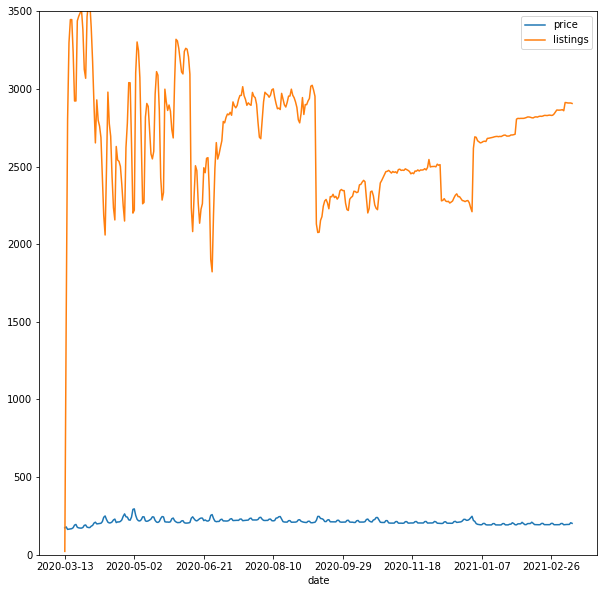

In [0]:
figToPlot = calender.filter("date > '2019-01-01'").filter("available == 't'").groupBy("date").agg(avg("price").alias("price"), count("listing_id").alias("listings")).toPandas().sort_values(by='date')\
.plot(x="date",y=["price","listings"],figsize =(10,10))

figToPlot.set_ylim(0,3500)

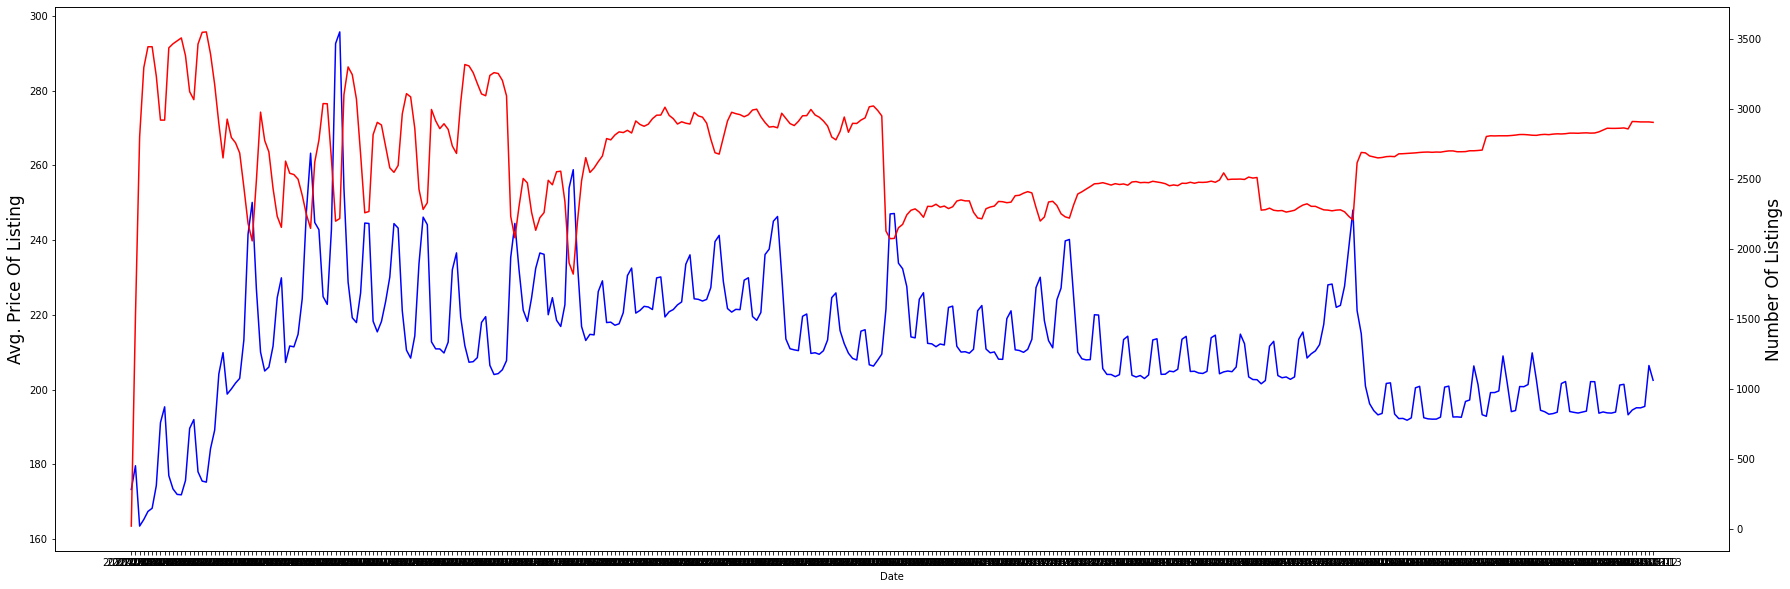

In [0]:
PriceByListings = calender.filter("date > '2019-01-01'").filter("available == 't'").groupBy("date").agg(avg("price").alias("price"), count("listing_id").alias("listings")).toPandas().sort_values(by='date')
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(30,10))
# make a plot
ax.plot(PriceByListings.date, PriceByListings.price, color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=10)
# set y-axis label
ax.set_ylabel("Avg. Price Of Listing",fontsize=17)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(PriceByListings.date, PriceByListings.listings,color="red")
ax2.set_ylabel("Number Of Listings",fontsize=17)
plt.show()

There is an obvious spike in today's time because of the lockdowns happening right!

Now let us see the number of listings



---



---



##Now that this is out of the way, Let us start analyzing the data that we have !

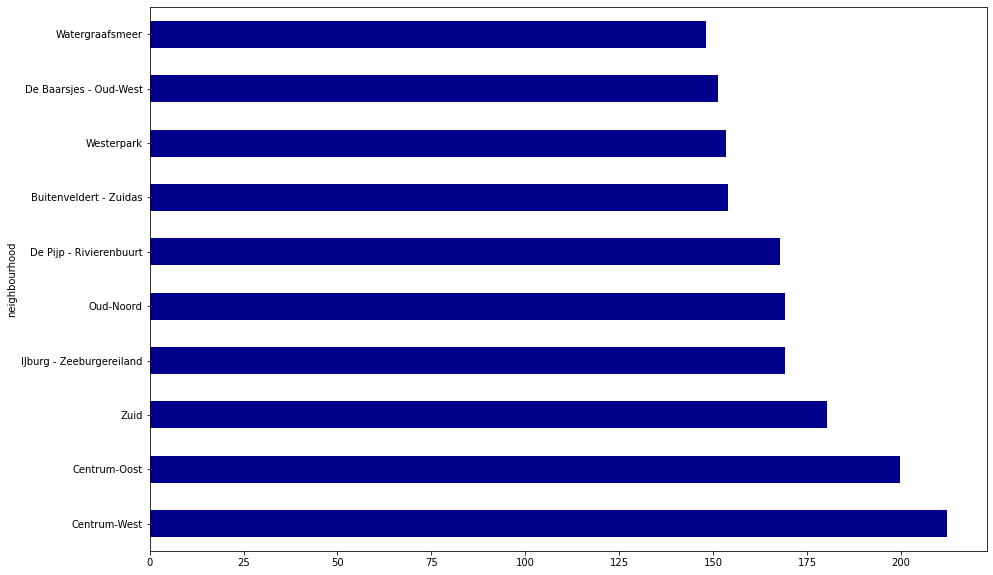

In [0]:
# The Most expensive neighbourhoods in Amsterdam
# From this result we can see that Centrum-West is averagely the most expensive AirBnB area, so we will dive deeper into it.

groupedNeighbouhoods = bigListings.groupBy("neighbourhood").agg(avg("price").alias("price"))
groupedNeighbouhoods.toPandas().sort_values(by=['price'], ascending=False)[:10].plot(kind='barh',x='neighbourhood', y='price', 
                figsize=(15,10), legend=False, color='darkblue')

I want to see where exactly is this neighborhood in the Amsterdam city,
And how concentrated are the listings in it.

In [0]:
expensiveNd = bigListings.filter("neighbourhood == 'Centrum-West'")


map2 = folium.Map(location=[52.3680, 4.9036],width=700,height=700, zoom_start=13)

lats2 = list(map(float, expensiveNd.select("latitude").rdd.map(lambda r : r[0]).collect()))

lons2 = list(map(float, expensiveNd.select("longitude").rdd.map(lambda r : r[0]).collect()))

locations2 = list(zip(lats2, lons2))

HeatMap(locations2, name="Concentration of the listings in Centrum-West" ).add_to(map2)

map2

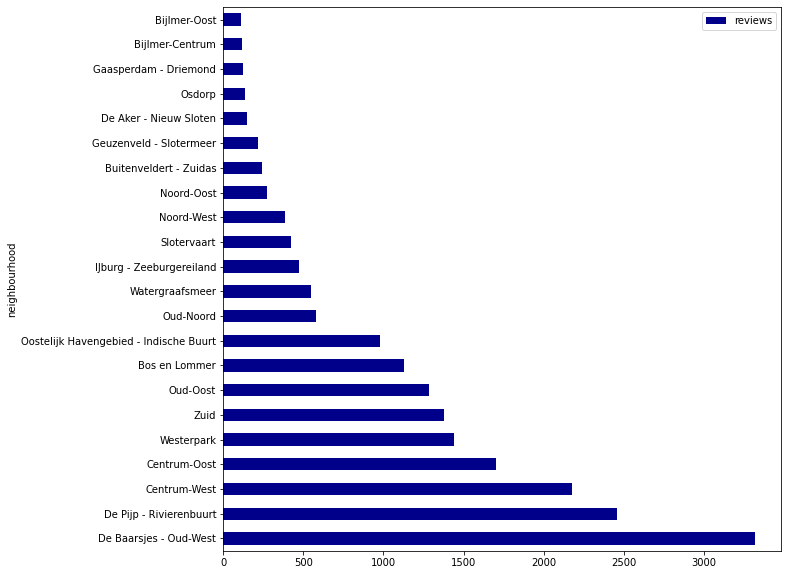

In [0]:
#Now I want to view which area has the most reviews

bigListings.groupby("neighbourhood").agg(count("number_of_reviews").alias("reviews")).toPandas().sort_values("reviews", ascending=False).plot(kind='barh', x='neighbourhood', y='reviews', 
                figsize=(10,10), color='darkblue')

Interesting enough, The most reviewed Neighbourhood is NOT the the most expensive one. But it is the 9th most expensive !




However, let us see where exactly is this area !

In [0]:
mostReviewed = bigListings.filter("neighbourhood == 'De Baarsjes - Oud-West'")


map3 = folium.Map(location=[52.3680, 4.8736],width=900,height=700, zoom_start=13)

lats3 = list(map(float, mostReviewed.select("latitude").rdd.map(lambda r : r[0]).collect()))

lons3 = list(map(float, mostReviewed.select("longitude").rdd.map(lambda r : r[0]).collect()))

locations3 = list(zip(lats3, lons3))

HeatMap(locations3, name="Concentration of reviews in De Baarsjes - Oud-West" ).add_to(map3)

map3

Most prefered 5 neighbourhoods

In [0]:
neighbour = listings.groupby("neighbourhood").agg(count("neighbourhood").alias("count")).sort(col("count").desc())

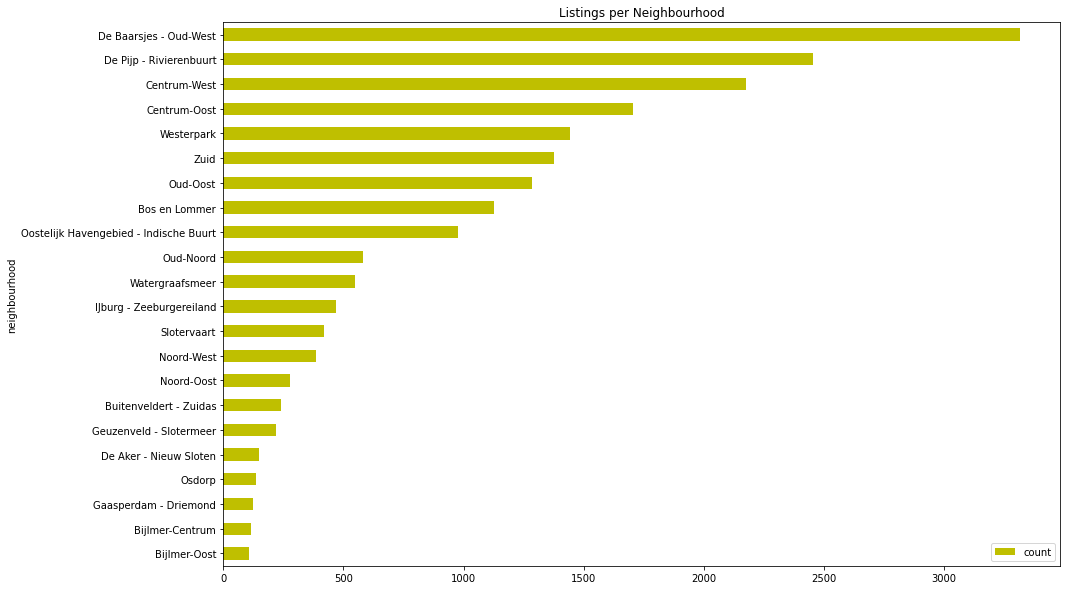

In [0]:
neighbour.sort(col("count")).toPandas().plot.barh(x = "neighbourhood", y = "count", figsize = (15,10), color = "y", title="Listings per Neighbourhood")

Average min nights per neighborhood

In [0]:
nights = listings.select("neighbourhood", "minimum_nights")

avgNights = nights.rdd.map(lambda x: (x[0], (1, x[1]))).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
          .map(lambda x: (x[0], round(x[1][1]/x[1][0], 2))).toDF().withColumnRenamed("_1", "neighbourhood")\
          .withColumnRenamed("_2", "Avg min nights").sort(col("Avg min nights").desc())

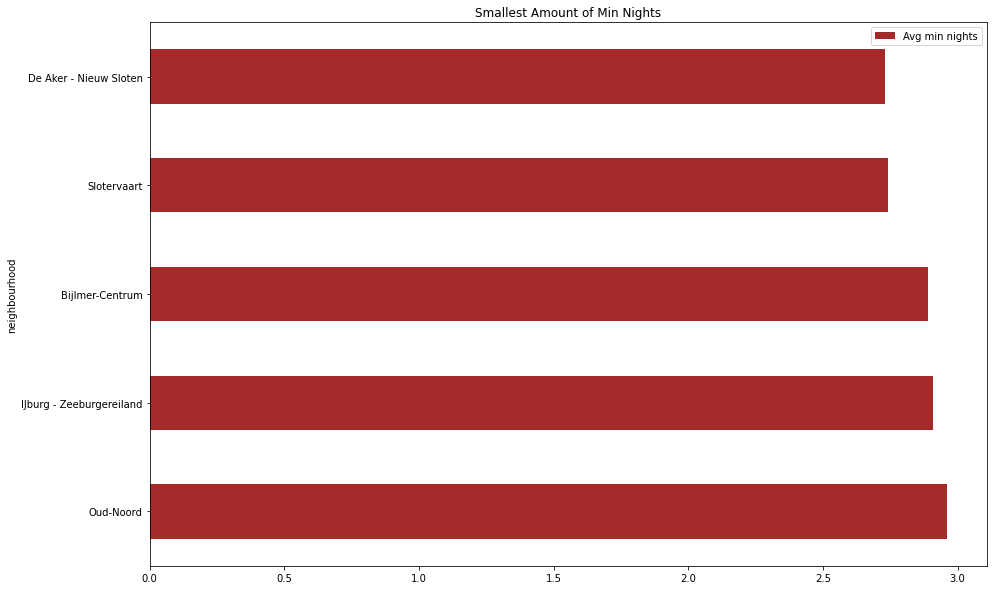

In [0]:
avgNights.sort(col("Avg min nights").desc()).toPandas()[-5:].plot.barh(x = "neighbourhood", y = "Avg min nights", figsize = (15,10), color = "brown", title="Smallest Amount of Min Nights")

If you are Traveling,these neighbourhoods are going to be your best option !



---
The following will show how many listings allow up to how many people to live in its **AirBnB**


In [0]:

#The following will show how many listings allow up to how many people to live in its **AirBnB**

AccomPerListing = bigListings.groupBy("accommodates").agg(count("accommodates").alias("Number Of Listings")).toPandas().dropna().sort_values("accommodates")

fig = px.pie(AccomPerListing, values='Number Of Listings', names='accommodates', title='Persons per Listing', width=1000,height=700)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

As anyone would have guessed, the most listings are made for 2 persons.
Followed by listings made for 4 persons.


---

But what is the average daily price for listings made for 2 persons in the neighbourhoods?



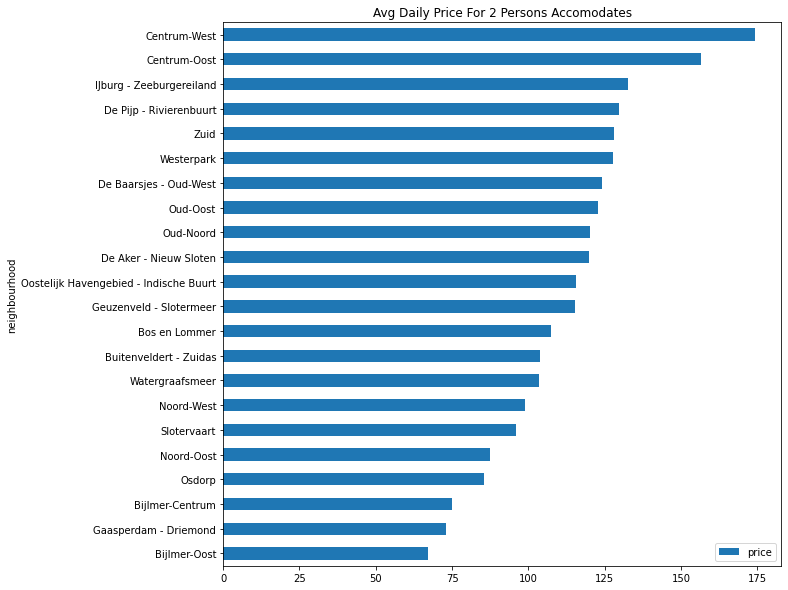

In [0]:
twopersonsListings = bigListings.filter("accommodates == 2")
twopersonsListings.groupBy("neighbourhood").agg(avg('price').alias('price')).toPandas().sort_values(by='price',ascending=True).plot.barh(x='neighbourhood',y='price',figsize=(10,10), title="Avg Daily Price For 2 Persons Accomodates")

Highest average is slightly **above 170**,
But there are people who says that Amsterdam is a **small city**, so don't pay too much just to live in the center of it, because you can live on the sides and still enjoy Amsterdam **at a much lower cost (around 65-70) per day**

That is saving more than double the price !!



---



---






We saw how many people most listings hold.
But how about which **room type** is going to be the most expensive?

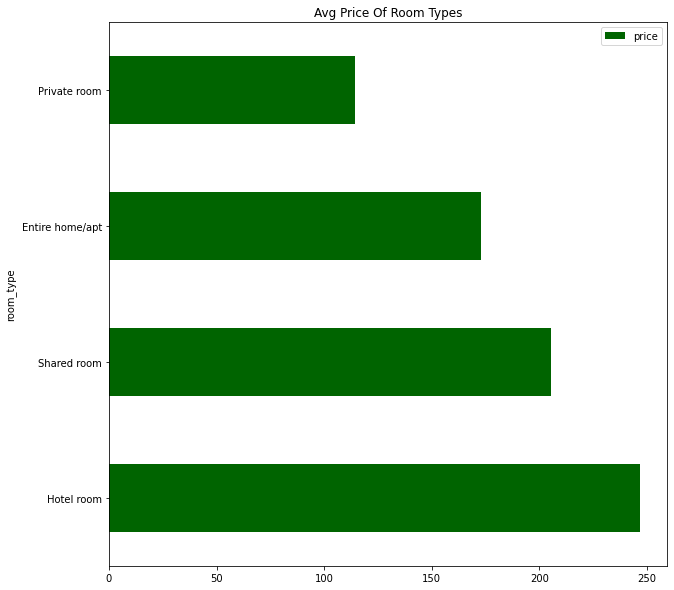

In [0]:
bigListings.groupby("room_type").agg(avg("price").alias("price")).toPandas().sort_values("price", ascending=False).plot(kind='barh', x='room_type', y='price', 
                figsize=(10,10), color='darkgreen', title="Avg Price Of Room Types")

Strange enough, the **shared room** is **more expensive** than a **private room.**

And obviously the **Hotel room is the most expensive** type of rooms, because you know... It is a Hotel.


---



---



#After this point, we will start working on our Machine learning Model
## We will start by finding the numerical features that most correlate with the price

But first thing I will do is normalize all the data (except price)

In [0]:
preparedData = bigListings.select([item[0] for item in bigListings.dtypes if item[1].startswith('double')]).drop("id","host_id")


for i in preparedData.columns:
  if i!="price":
    (mean_view, std_view) = preparedData.select(mean(i), stddev(i)).first()
    preparedData = preparedData.withColumn(i, (col(i) - mean_view) / std_view)

preparedData.show(5)


+--------------------+-------------------+-----+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+----------------------+----------------------+---------------------------+---------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+
|            latitude|          longitude|price|       accommodates|          bathrooms|           bedrooms|               beds|        cleaning_fee|    security_deposit|      minimum_nights|      maximum_nights|   number_of_reviews| review_scores_value|review_scores_cleanliness|review_scores_location|review_scores_accuracy|review_scores_communication|review_scores_checkin|review_scores_rating|   reviews_per_month|    availability_30|    availability_60|    availability_90|   availability_365|
+-

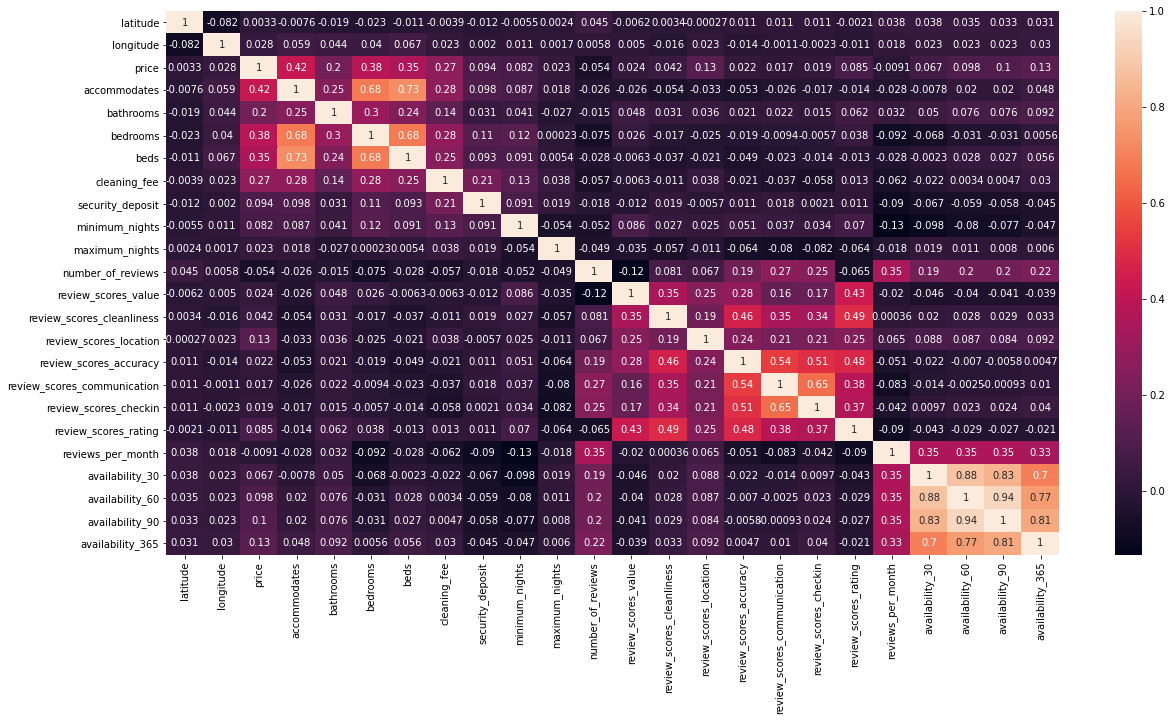

In [0]:
import seaborn as sns

correlation_map = preparedData.toPandas().corr(method='kendall')
plt.figure(figsize=(20,10))
sns.heatmap(correlation_map, annot=True)

In the correlation map we can observe that most of these values do have an effect on the Price of a listing.
However, **only SOME** of them has a higher correlation level than the rest, so we will train our model according to these values

In order to train an ML model,
first thing to do is to **vectorize** my data

In [0]:
features = preparedData.select('accommodates','bathrooms','bedrooms','beds','cleaning_fee','security_deposit', 'number_of_reviews', 'availability_60', 'availability_90', 'availability_365')


vectorAssembler = VectorAssembler(inputCols = features.columns, outputCol = 'features')
vhouse_df = vectorAssembler.transform(preparedData)
vhouse_df = vhouse_df.select(['features', 'price'])
vhouse_df.show(3)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[-0.6656534476733...|109.0|
|[-0.6656534476733...|108.0|
|[0.88075130788705...|149.0|
+--------------------+-----+
only showing top 3 rows



Then I **split** the data into a training set and a testing set

In [0]:
(training, test) = vhouse_df.randomSplit([0.7, 0.3])

###Finally, it is time to train our model :D !

In [0]:
#Now for our model
rfr = RandomForestRegressor(featuresCol = 'features', labelCol='price', numTrees=70)
rfr_model = rfr.fit(training)

In [0]:
rfr_predictions = rfr_model.transform(test)
rfr_predictions.select("prediction","price","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
rfr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="price",metricName="r2")
print("R Squared (R2) on test data = %g" % rfr_evaluator.evaluate(rfr_predictions))

####Turns out our model wasn't as good as I hoped :|

# Review Evaluation




---



In this code block we trained a model to determine if a written review by a specific person is good or bad. Then we calculated the avg rating per person and listed the top 5.


In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import count
from pyspark.sql.types import FloatType,IntegerType


In order to apply the Review Text in our ML model, first thing we need to do is turn the words/letters into a numerical format. Because that is the best way for an ML model to read them properly.

In [0]:
train = reviews_date = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Project/train.csv", header=True,  inferSchema=True, mode="DROPMALFORMED")

train = train.withColumn("label", train["label"].cast('float'))
interim = train.rdd.filter(lambda x: type(x[1]) is float).map(lambda t: Row(label = float(t[1]), text = str(t[0])))


training = spark.createDataFrame(interim)



tokenizer = Tokenizer(inputCol = "text", outputCol = "words")
hashingTF = HashingTF(inputCol = tokenizer.getOutputCol(), outputCol = "features")
lr = LogisticRegression(maxIter = 10, regParam = 0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])



model = pipeline.fit(training)

comments = reviews_detailed.withColumn("text", col("comments")).na.drop()

prediction = model.transform(comments)

prediction = prediction.select("comments", "prediction")



In [0]:
hosts = listings.select("host_name").na.drop().distinct()
df = hosts.toPandas().join(prediction.toPandas())

reviews = spark.createDataFrame(df)

reviews.show()


+-----------------+--------------------+----------+
|        host_name|            comments|prediction|
+-----------------+--------------------+----------+
|         Bastiaan|Daniel is really ...|       0.0|
|           Dorien|Daniel is the mos...|       1.0|
|Lodewijk & Esther|We had such a gre...|       1.0|
|             Faye|Very professional...|       1.0|
| Ruud & Esmeralda|Daniel is highly ...|       1.0|
|         Laurence|Daniel was a grea...|       1.0|
|      Jean-Michel|Daniele is an ama...|       0.0|
|             Bogy|You can´t have a ...|       1.0|
|            Tyler|Daniel was a fant...|       1.0|
|         Francois|Daniel was great....|       1.0|
|          Folkert|Daniel has been m...|       0.0|
|            Guyon|Daniel's apartmen...|       1.0|
|           Carmit|Daniel was an exe...|       1.0|
|             July|No amount of prai...|       1.0|
|              R.A|It's the perfect ...|       1.0|
|          Roeland|When you reach at...|       1.0|
|           

In [0]:
host_names = [row.host_name for row in hosts.collect()]

rew = reviews.rdd.map(lambda x: (x[0], ((1, x[2]), x[1]), "null")).toDF().withColumnRenamed("_1", "Host Name").withColumnRenamed("_2", "Comments").drop("_3")
                                                            

rew.show()

+-----------------+--------------------+
|        Host Name|            Comments|
+-----------------+--------------------+
|         Bastiaan|[[1, 0.0], Daniel...|
|           Dorien|[[1, 1.0], Daniel...|
|Lodewijk & Esther|[[1, 1.0], We had...|
|             Faye|[[1, 1.0], Very p...|
| Ruud & Esmeralda|[[1, 1.0], Daniel...|
|         Laurence|[[1, 1.0], Daniel...|
|      Jean-Michel|[[1, 0.0], Daniel...|
|             Bogy|[[1, 1.0], You ca...|
|            Tyler|[[1, 1.0], Daniel...|
|         Francois|[[1, 1.0], Daniel...|
|          Folkert|[[1, 0.0], Daniel...|
|            Guyon|[[1, 1.0], Daniel...|
|           Carmit|[[1, 1.0], Daniel...|
|             July|[[1, 1.0], No amo...|
|              R.A|[[1, 1.0], It's t...|
|          Roeland|[[1, 1.0], When y...|
|             Rony|[[1, 0.0], Daniel...|
|           Britta|[[1, 1.0], Daniel...|
|            Mojan|[[1, 1.0], Our st...|
|           Talisa|[[1, 1.0], Daniel...|
+-----------------+--------------------+
only showing top

In [0]:

def name(var):
  for i in host_names:
    if len(i) < 3: continue
  
    elif i in var: return i


collect = rew.rdd.map(lambda x: (name(str(x[1])), x[1][0])).reduceByKey(lambda x,y: (x[0]+y[0], x[1] + y[1])).toDF().withColumnRenamed("_1", "Host Name").withColumnRenamed("_2", "Comments")
collect.show()

+----------+--------------+
| Host Name|      Comments|
+----------+--------------+
|      Dani|  [235, 209.0]|
|      null|[1354, 1109.0]|
|       Don|      [8, 6.0]|
|       Nic|  [139, 116.0]|
|       Bar|    [16, 10.0]|
|       Ton|      [2, 2.0]|
|      Karl|      [1, 1.0]|
|    Chanti|      [1, 1.0]|
|      Alex|  [145, 121.0]|
|       Han|      [2, 0.0]|
|       Mai|      [1, 1.0]|
|    Sydney|      [2, 2.0]|
|     Chris|      [9, 9.0]|
|       Per|    [84, 71.0]|
|       Rem|     [11, 9.0]|
|Appartment|      [5, 3.0]|
|       Roy|      [3, 2.0]|
|       Eve|    [60, 48.0]|
|       May|      [4, 4.0]|
|      Marc|    [55, 47.0]|
+----------+--------------+
only showing top 20 rows



In [0]:
def divide(var):
  try:
    return round(var[1] / var[0], 2)
  except ZeroDivisionError:
    return 0

final = collect.rdd.map(lambda x: (x[0], divide(x[1]))).filter(lambda x: x[1]<0.9).toDF().withColumnRenamed("_1", "Host Name").withColumnRenamed("_2", "Comments")
final.show()

+----------+--------+
| Host Name|Comments|
+----------+--------+
|      Dani|    0.89|
|      null|    0.82|
|       Don|    0.75|
|       Nic|    0.83|
|       Bar|    0.62|
|      Alex|    0.83|
|       Han|     0.0|
|       Per|    0.85|
|       Rem|    0.82|
|Appartment|     0.6|
|       Roy|    0.67|
|       Eve|     0.8|
|      Marc|    0.85|
|      Just|    0.82|
|       Luc|     0.5|
|       Fre|     0.0|
|     Edwin|    0.83|
|       Chi|    0.71|
|    Edward|     0.0|
|     Merel|     0.0|
+----------+--------+
only showing top 20 rows



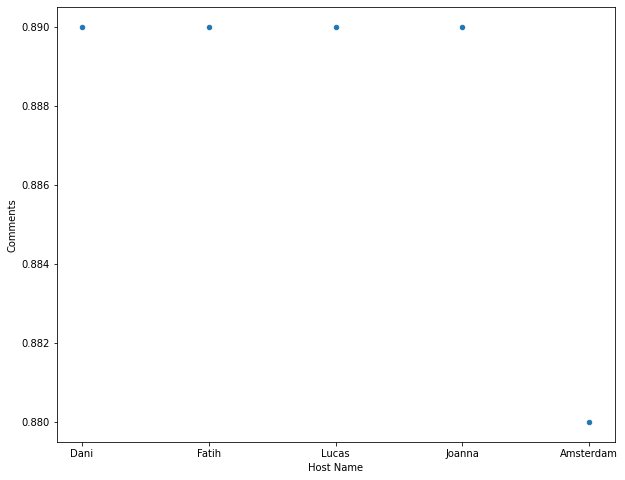

In [0]:
final.toPandas().sort_values(by = ["Comments"], ascending = False)[:5].plot(kind = "scatter", x = "Host Name", y = "Comments", figsize=(10, 8))

According to our results, the best hosts that people should go to are : Dani,Fatih, Lucas and Joanna.